# Analysis of Reuslts (Plots and Statistics)

In [1]:
# import libs
import glob
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.style.use('seaborn-whitegrid')
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import scipy as sp

> Note we use active and inactive for advantaged and disadvantaged users interchangeably.

> We also use (N, Original, fairness-unaware) and (C, Fair, fairness-aware) interchangeably.

## 1. Configuration

In [2]:
# select user grouping method to read the releated results: interactions (005) or popular consumption (2)
user_groups = "005" # 005 or 2
# root path of the results
results_path = "results/" + user_groups + "/"
# the list of exsiting datasets
datasets = ['Epinion', 'MovieLens', 'BookCrossing', 'AmazonOffice', 'AmazonToy', 'Gowalla', 'LastFM', 'Foursquare']
Models = ['MostPop', 'BPR', 'PF', 'WMF', 'NeuMF', 'VAECF']

## 2. Read the results files

In [3]:
# create a list of all results file for all datasets: 8 datasets * 6 models = 48 results files
# path of all the results files
results_files = []

for dataset in datasets:
    for file in glob.glob(results_path + dataset + "/*.csv"):
        # add ot list of all files paths
        results_files.append(file)
print(f"No. of files: {len(results_files)}")

No. of files: 48


In [4]:
# load results files into pandas dataframe as csv files
all_dfs = []

for result_file in results_files:
    result_df = pd.read_csv(result_file, sep=",")
    all_dfs.append(result_df)

# concat all of the dataframes
results_df = pd.concat(all_dfs)

In [5]:
# sort results dataframe wrt datasets, model, then the type which is N (fairness-unaware) or C (user-fairness-aware)
# this helps to have the same order of datasets and models in different plots
results_df = results_df.sort_values(["Dataset", "Model", 'Type'], ascending = (False, True, False))

In [6]:
results_df.head()

,Dataset,Model,GUser,GItem,Type,User_EPS,Item_EPS,ndcg_ALL,ndcg_ACT,ndcg_INACT,...,Nov_ACT,Nov_INACT,Cov_ALL,Cov_ACT,Cov_INACT,Active_GAP,Inactive_Gap,Short_Items,Long_Items,All_Items
0,MovieLens,BPR,005%,020%,N,-,-,0.08375,0.14968,0.08028,...,1.89491,1.89617,0.96,0.89,0.89,168.476,90.704,9430.0,0.0,9430==9430.0
1,MovieLens,BPR,005%,020%,C,0.0000000,-,0.11409,0.03322,0.11834,...,1.92180,1.93680,1.93,1.63,1.85,163.457,85.192,9430.0,0.0,9430==9430.0
2,MovieLens,BPR,005%,020%,C,165.4166667,-,0.11178,0.04056,0.11553,...,1.92509,1.93943,1.78,1.56,1.70,162.783,84.789,9430.0,0.0,9430==9430.0
3,MovieLens,BPR,005%,020%,C,330.8333333,-,0.10931,0.05200,0.11233,...,1.92181,1.94026,1.78,1.56,1.70,162.687,84.724,9430.0,0.0,9430==9430.0
4,MovieLens,BPR,005%,020%,C,496.2500000,-,0.10525,0.05911,0.10768,...,1.92130,1.93996,1.70,1.48,1.63,163.694,84.770,9430.0,0.0,9430==9430.0


In [7]:
# This method computes the UGF (user group fainress which is the disparity or difference between user groups)
def UGF(row):
    return round(row['ndcg_ACT'] - row['ndcg_INACT'], 4)

# Here, we add a new column to show the UGF on NDCG of adv. and disadv. users in the all results dataframe 
results_df['UGF'] = results_df.apply(lambda row: UGF(row), axis=1)

In [8]:
# To check the last column of the dataframe
results_df.head()

,Dataset,Model,GUser,GItem,Type,User_EPS,Item_EPS,ndcg_ALL,ndcg_ACT,ndcg_INACT,...,Nov_INACT,Cov_ALL,Cov_ACT,Cov_INACT,Active_GAP,Inactive_Gap,Short_Items,Long_Items,All_Items,UGF
0,MovieLens,BPR,005%,020%,N,-,-,0.08375,0.14968,0.08028,...,1.89617,0.96,0.89,0.89,168.476,90.704,9430.0,0.0,9430==9430.0,0.0694
1,MovieLens,BPR,005%,020%,C,0.0000000,-,0.11409,0.03322,0.11834,...,1.93680,1.93,1.63,1.85,163.457,85.192,9430.0,0.0,9430==9430.0,-0.0851
2,MovieLens,BPR,005%,020%,C,165.4166667,-,0.11178,0.04056,0.11553,...,1.93943,1.78,1.56,1.70,162.783,84.789,9430.0,0.0,9430==9430.0,-0.0750
3,MovieLens,BPR,005%,020%,C,330.8333333,-,0.10931,0.05200,0.11233,...,1.94026,1.78,1.56,1.70,162.687,84.724,9430.0,0.0,9430==9430.0,-0.0603
4,MovieLens,BPR,005%,020%,C,496.2500000,-,0.10525,0.05911,0.10768,...,1.93996,1.70,1.48,1.63,163.694,84.770,9430.0,0.0,9430==9430.0,-0.0486


In [9]:
# grouping results on dataset
ds_group_results_df = results_df.groupby('Dataset')

# to extract and analyse the results
def main_results_extraction(dataset='Epinion', model='NeuMF'):
    global heatmap_df
    global boxplot_df
    global boxplot_UGF_df
    # grouping reuslts on each dataset based on the model
    ml_group_results_df = ds_group_results_df.get_group(dataset).groupby('Model')
    # get the results of the model
    model_df = ml_group_results_df.get_group(model)
    # get the results of fairness-unaware model
    N_df = model_df[(model_df.Type == 'N')]
    '''
    As we have the results of fairness-aware model on different epsilon values, here we would selcet the best one to report. The idea is the lower the parity (UGF),
    the better the performance. Thus, we first check if we have at least one value of UGF greater than 0 (we have at least one positive value) then we select the lowest
    one. Otherwise, we selcet the maximum value between all the negative values.
    '''
    C_df = model_df[(model_df.Type == 'C') & (model_df.UGF > 0)]
    if C_df.empty == True:
        # all UGfs are negative, the maximum one should be selected.
        C_df = model_df[(model_df.Type == 'C') & (model_df.UGF == model_df.UGF.max())]
    else:
        # we have at leasto ne positive value and we select the lowest one
        C_df = C_df[C_df.UGF == C_df.UGF.min()]

    # the round of UGF for N and C
    _UGF_N = round(N_df.UGF.values[0], 4)
    _UGF_C = round(C_df.UGF.values[0], 4)

    # the round of NDCG for all for N and C
    _NDCG_N = round(N_df.ndcg_ALL.values[0], 4)
    _NDCG_C = round(C_df.ndcg_ALL.values[0], 4)

    # the round of Novelty for all for N and C
    _Nov_N = round(N_df.Nov_ALL.values[0], 4)
    _Nov_C = round(C_df.Nov_ALL.values[0], 4)

    # the average (called DeltaGAP) of Delta GAP for active and inactive user groups for N and C
    _DeltaGAP_N = round(abs(N_df.Active_GAP.values[0] + N_df.Inactive_Gap.values[0]), 4) / 2
    _DeltaGAP_C = round(abs(C_df.Active_GAP.values[0] + C_df.Inactive_Gap.values[0]), 4) / 2

    # Here we print the results in the format of the tables in the paper (latex format) to be easily adopted to latex format and added to the paper.
    print(f"\multirow{{2}}{{*}}{{{N_df.Model.values[0]}}} & Org. & {round(N_df.ndcg_ALL.values[0], 4)} & {round(N_df.ndcg_ACT.values[0], 4)} & {round(N_df.ndcg_INACT.values[0], 4)} & {round(N_df.UGF.values[0], 4)} & {round(abs((_UGF_N - _UGF_N) / _UGF_N) * 100, 2)} && {round(N_df.Nov_ALL.values[0], 4)} & {N_df.Cov_ALL.values[0]} & {round(N_df.Short_Items.values[0], 4)} & {round(N_df.Long_Items.values[0], 4)} & {round(N_df.Active_GAP.values[0], 4)} & {round(N_df.Inactive_Gap.values[0], 4)} \\\\")
    print(f"                       & Fair & {round(C_df.ndcg_ALL.values[0], 4)} & {round(C_df.ndcg_ACT.values[0], 4)} & {round(C_df.ndcg_INACT.values[0], 4)} & {round(C_df.UGF.values[0], 4)} & {round(abs((_UGF_C - _UGF_N) / _UGF_N) * 100, 2)} && {round(C_df.Nov_ALL.values[0], 4)} & {C_df.Cov_ALL.values[0]} & {round(C_df.Short_Items.values[0], 4)} & {round(C_df.Long_Items.values[0], 4)} & {round(C_df.Active_GAP.values[0], 4)} & {round(C_df.Inactive_Gap.values[0], 4)} \\\ \hline")
    
    # We write the results to CSV files to save them for furthur analysis
    result_table.write(f"{N_df.Model.values[0]},Org.,{round(N_df.ndcg_ALL.values[0], 4)},{round(N_df.ndcg_ACT.values[0], 4)},{round(N_df.ndcg_INACT.values[0], 4)},{round(N_df.UGF.values[0], 4)},{round(abs((_UGF_N - _UGF_N) / _UGF_N) * 100, 2)},{round(N_df.Nov_ALL.values[0], 4)},{N_df.Cov_ALL.values[0]},{round(N_df.Short_Items.values[0], 4)},{round(N_df.Long_Items.values[0], 4)},{round(N_df.Active_GAP.values[0], 4)},{round(N_df.Inactive_Gap.values[0], 4)} \n")
    result_table.write(f"{C_df.Model.values[0]},Fair,{round(C_df.ndcg_ALL.values[0], 4)},{round(C_df.ndcg_ACT.values[0], 4)},{round(C_df.ndcg_INACT.values[0], 4)},{round(C_df.UGF.values[0], 4)},{round(abs((_UGF_C - _UGF_N) / _UGF_N) * 100, 2)},{round(C_df.Nov_ALL.values[0], 4)},{C_df.Cov_ALL.values[0]},{round(C_df.Short_Items.values[0], 4)},{round(C_df.Long_Items.values[0], 4)},{round(C_df.Active_GAP.values[0], 4)},{round(C_df.Inactive_Gap.values[0], 4)} \n")
    ### heatmap_df = heatmap_df.append({'Dataset': model_df.Dataset.values[0], 'Group': 'All', 'Model': model_df.Model.values[0], 'Precision': model_df.Pre_ALL.values[0]}, ignore_index=True)
    ### N

    # To creat heatmap
    heatmap_df = heatmap_df.append({'Dataset': model_df.Dataset.values[0],'Group': 'Org.', 'Model': model_df.Model.values[0], 'UGF': (N_df.Pre_ACT.values[0] - N_df.Pre_INACT.values[0])}, ignore_index=True)
    heatmap_df = heatmap_df.append({'Dataset': model_df.Dataset.values[0],'Group': 'Fair', 'Model': model_df.Model.values[0], 'UGF': (C_df.Pre_ACT.values[0] - C_df.Pre_INACT.values[0])}, ignore_index=True)
    ### heatmap_df = heatmap_df.append({'Dataset': model_df.Dataset.values[0],'Group': 'Fair (Act.)', 'Model': model_df.Model.values[0], 'Precision': C_df.Pre_ACT.values[0]}, ignore_index=True)
    ### heatmap_df = heatmap_df.append({'Dataset': model_df.Dataset.values[0],'Group': 'Fair (Inact.)', 'Model': model_df.Model.values[0], 'Precision': C_df.Pre_INACT.values[0]}, ignore_index=True)

    # To create box plot
    boxplot_df = boxplot_df.append({'Dataset': model_df.Dataset.values[0], 'Model': model_df.Model.values[0], 'Type': 'Original', 'UGF': N_df.UGF.values[0], 'impNDCG': round(abs((_NDCG_N - _NDCG_N) / _NDCG_N) * 100, 2), 'impNov': round(abs((_Nov_N - _Nov_N) / _Nov_N) * 100, 2), 'Cov': N_df.Cov_ALL.values[0], 'DeltaGAP': round(N_df.Active_GAP.values[0] - N_df.Inactive_Gap.values[0], 4), 'avgDeltaGap': _DeltaGAP_N, 'impDeltaGap':round((_DeltaGAP_N - _DeltaGAP_N) / _DeltaGAP_N, 5), 'impUGF': round(abs((_UGF_N - _UGF_N) / _UGF_N) * 100, 2), 'cntLongItems': round(N_df.Long_Items.values[0], 4)}, ignore_index=True)
    boxplot_df = boxplot_df.append({'Dataset': model_df.Dataset.values[0], 'Model': model_df.Model.values[0], 'Type': 'Fair', 'UGF': C_df.UGF.values[0], 'impNDCG': round(abs((_NDCG_C - _NDCG_N) / _NDCG_N) * 100, 2), 'impNov': round(abs((_Nov_C - _Nov_N) / _Nov_N) * 100, 2), 'Cov': C_df.Cov_ALL.values[0], 'DeltaGAP': round(C_df.Active_GAP.values[0] - C_df.Inactive_Gap.values[0], 4), 'avgDeltaGap': _DeltaGAP_C, 'impDeltaGap': round((_DeltaGAP_C - _DeltaGAP_N) / _DeltaGAP_N, 5), 'impUGF': round(abs((_UGF_C - _UGF_N) / _UGF_N) * 100, 2), 'cntLongItems': round(C_df.Long_Items.values[0], 4)}, ignore_index=True)

    # To ...
    boxplot_UGF_df = boxplot_UGF_df.append({'Dataset': model_df.Dataset.values[0], 'Model': model_df.Model.values[0], 'UGF-Org': N_df.UGF.values[0], 'UGF-Fair': round(abs((_UGF_C - _UGF_N)), 2)}, ignore_index=True)

In [10]:
heatmap_df = pd.DataFrame(columns=['Dataset', 'Group', 'Model', 'UGF']) # UGF on Precision
boxplot_df = pd.DataFrame(columns=['Dataset', 'Model','Type', 'UGF', 'impNDCG', 'impNov', 'Cov', 'DeltaGAP', 'avgDeltaGap','impDeltaGap', 'impUGF', 'cntLongItems'])
boxplot_UGF_df = pd.DataFrame(columns=['Dataset', 'Model', 'UGF-Org', 'UGF-Fair'])

# iterate on models and dataset to create result files, tables, and compute main results
# latex table format will be written to copy-paste to latex template.
for dataset in datasets:
    result_table = open(f"tables/{user_groups}/result_table_{dataset}.csv", 'w')
    result_table.write("Model,Type,All,Adv,Disadv,UGF,Δ%,Nov,Cov,Short,Long,ΔGapA,ΔGapD \n")
    print(f"> Dataset: {dataset}")
    for model in Models:
        main_results_extraction(dataset=dataset, model=model)
    result_table.close()

> Dataset: Epinion
\multirow{2}{*}{MostPop} & Org. & 0.0302 & 0.0566 & 0.0288 & 0.0278 & 0.0 && 3.7133 & 0.49 & 26770.0 & 0.0 & 255.307 & 204.721 \\
                       & Fair & 0.0301 & 0.0374 & 0.0298 & 0.0077 & 72.3 && 3.7123 & 2.43 & 26770.0 & 0.0 & 287.94 & 205.039 \\ \hline
\multirow{2}{*}{BPR} & Org. & 0.0297 & 0.055 & 0.0283 & 0.0267 & 0.0 && 3.703 & 0.63 & 26770.0 & 0.0 & 257.095 & 206.271 \\
                       & Fair & 0.0316 & 0.0384 & 0.0312 & 0.0071 & 73.41 && 3.6658 & 1.55 & 26770.0 & 0.0 & 291.545 & 217.278 \\ \hline
\multirow{2}{*}{PF} & Org. & 0.0321 & 0.0751 & 0.0298 & 0.0453 & 0.0 && 4.9602 & 50.73 & 22169.0 & 4601.0 & 83.502 & 61.209 \\
                       & Fair & 0.0364 & 0.0504 & 0.0356 & 0.0148 & 67.33 && 5.016 & 51.12 & 21872.0 & 4898.0 & 90.315 & 53.907 \\ \hline
\multirow{2}{*}{WMF} & Org. & 0.0235 & 0.0577 & 0.0217 & 0.036 & 0.0 && 4.9483 & 29.13 & 25225.0 & 1545.0 & 72.469 & 41.703 \\
                       & Fair & 0.0255 & 0.0417 & 0.0246 & 0.01

In [11]:
# to report the numebr of long-tail items per model on Original/Fair results
for model in Models:
    longitems_df = boxplot_df[(boxplot_df.Type == 'Original') & (boxplot_df.Model == model)]['cntLongItems']
    print(f"{model}: {np.mean(longitems_df)}")

MostPop: 0.0
BPR: 0.0
PF: 5083.0
WMF: 6211.875
NeuMF: 157.0
VAECF: 3102.75


0.44465 0.0015438


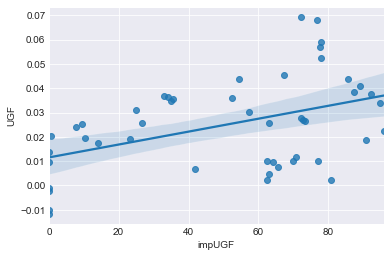

In [12]:
### WILL BE CHECKED LATER

impUGF_fair_df = boxplot_df[boxplot_df.Type == 'Fair']['impUGF']
UGF_org_df = boxplot_df[boxplot_df.Type == 'Original']['UGF']

sns.regplot(x=impUGF_fair_df, y=UGF_org_df)

# correlation between the UGF improvement on fair models and UGF on the original models
# Pearson's correlation coefficient and Two-tailed p-value.
pearsonr, pvalue = sp.stats.pearsonr(impUGF_fair_df, UGF_org_df)
print(round(pearsonr, 5) , round(pvalue, 7))

In [13]:
### NOT SURE WHERE WE NEEDED THEM
# get the average on the improvement of NDCG, Novelty, UGF, and DeltaGap 
avg_df = boxplot_df[boxplot_df.Type == 'Fair']
np.mean(avg_df.impNDCG), np.mean(avg_df.impNov), np.mean(avg_df.impUGF), np.mean(avg_df.impDeltaGap), np.mean(avg_df.avgDeltaGap)

(6.473541666666667,
 0.3958333333333333,
 50.9625,
 0.006763333333333334,
 97.063375)

In [14]:
# %improvmenet for each model on original and fair type on all dataset

def get_model_average_UGF(type='Original'):
    boxplot_type_df = boxplot_df[boxplot_df.Type == type].groupby('Model')
    print(f"The average of UGF on each model for the {type} version ...")
    Models = ['MostPop', 'BPR', 'PF', 'WMF', 'NeuMF', 'VAECF']
    for eachmodel in Models:
        print(f"{eachmodel}: {round(np.mean(boxplot_type_df.get_group(eachmodel)['impUGF']), 4)}")

for type in ['Original', 'Fair']:
    get_model_average_UGF(type=type)

The average of UGF on each model for the Original version ...
MostPop: 0.0
BPR: 0.0
PF: 0.0
WMF: 0.0
NeuMF: 0.0
VAECF: 0.0
The average of UGF on each model for the Fair version ...
MostPop: 53.7762
BPR: 49.9638
PF: 40.3712
WMF: 68.5475
NeuMF: 51.1875
VAECF: 41.9288


In [15]:
# sort results of heatmap dataframe
heatmap_df = heatmap_df.sort_values(["Dataset", "Model", 'Group'], ascending = (False, True, True))
# group heatmap dataframe by model
group_heatmap_df = heatmap_df.groupby('Model')

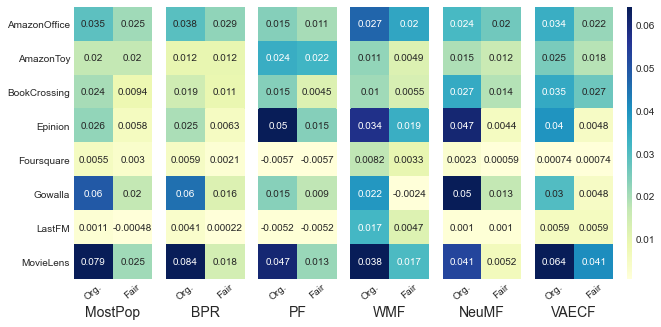

In [16]:
# generating heatmap for original and fair on UGF of Precision

df_Pop = group_heatmap_df.get_group('MostPop').pivot("Dataset", "Group", "UGF")
df_BPR = group_heatmap_df.get_group('BPR').pivot("Dataset", "Group", "UGF")
df_PF = group_heatmap_df.get_group('PF').pivot("Dataset", "Group", "UGF")
df_WMF = group_heatmap_df.get_group('WMF').pivot("Dataset", "Group", "UGF")
df_NeuMF = group_heatmap_df.get_group('NeuMF').pivot("Dataset", "Group", "UGF")
df_VAECF = group_heatmap_df.get_group('VAECF').pivot("Dataset", "Group", "UGF")

f,(ax0,ax1,ax2,ax3,ax4,ax5,axcb) = plt.subplots(1,7, gridspec_kw={'width_ratios':[1,1,1,1,1,1,0.06]}, figsize=(10, 5))

g0 = sns.heatmap(data=df_Pop.reindex(['Org.', 'Fair'], axis=1), annot=True, cmap="YlGnBu", cbar=False, ax=ax0)
g0.set_ylabel('')
g0.set_xlabel('MostPop', fontsize=14)

g1 = sns.heatmap(data=df_BPR.reindex(['Org.', 'Fair'], axis=1),annot=True, cmap="YlGnBu",cbar=False,ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('BPR', fontsize=14)
g1.set_yticks([])

g2 = sns.heatmap(data=df_PF.reindex(['Org.', 'Fair'], axis=1),annot=True, cmap="YlGnBu",cbar=False,ax=ax2)
g2.set_ylabel('')
g2.set_xlabel('PF', fontsize=14)
g2.set_yticks([])

g3 = sns.heatmap(data=df_WMF.reindex(['Org.', 'Fair'], axis=1),annot=True, cmap="YlGnBu",cbar=False,ax=ax3)
g3.set_ylabel('')
g3.set_xlabel('WMF', fontsize=14)
g3.set_yticks([])

g4 = sns.heatmap(data=df_NeuMF.reindex(['Org.', 'Fair'], axis=1),annot=True, cmap="YlGnBu",cbar=False,ax=ax4)
g4.set_ylabel('')
g4.set_xlabel('NeuMF', fontsize=14)
g4.set_yticks([])

g5 = sns.heatmap(data=df_VAECF.reindex(['Org.', 'Fair'], axis=1),annot=True, cmap="YlGnBu",ax=ax5, cbar_ax=axcb)
g5.set_ylabel('')
g5.set_xlabel('VAECF', fontsize=14)
g5.set_yticks([])

# may be needed to rotate the ticklabels correctly:
for ax in [g0,g1,g2,g3,g4,g5]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=40)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

plt.savefig(f'plots/{user_groups}/heatmap_{user_groups}.pdf', bbox_inches='tight')

In [17]:
# group boxplot on datasets
group_boxplot_df = boxplot_df.groupby('Dataset')

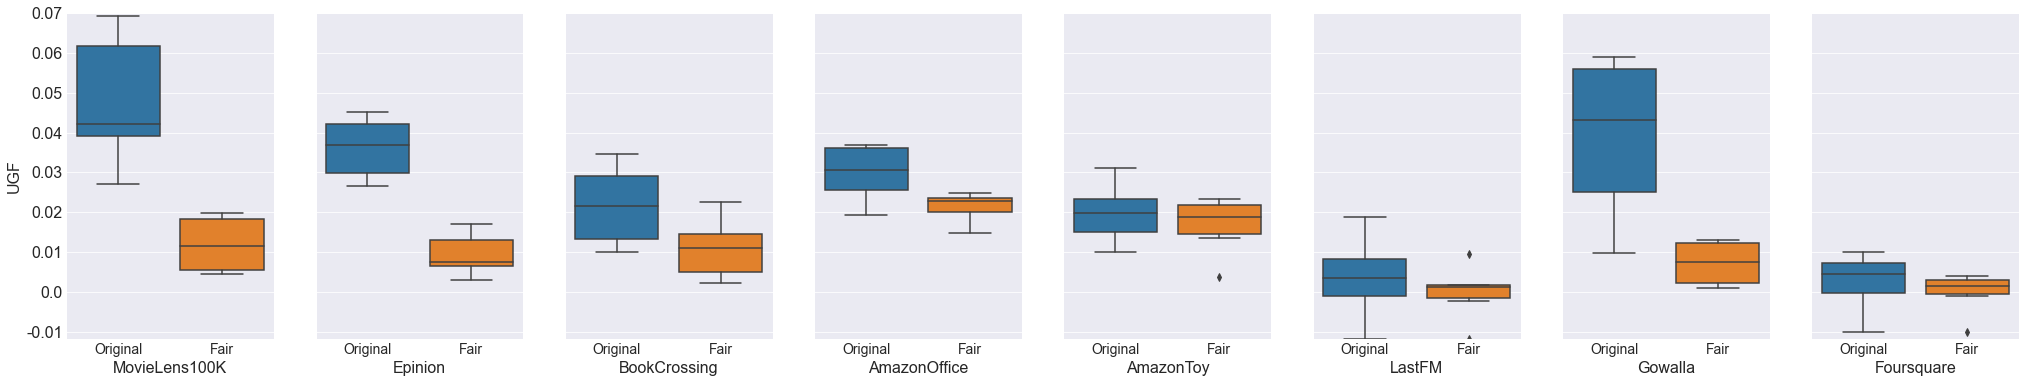

In [18]:
import seaborn  as sns
import matplotlib.pyplot as plt

# plt.xticks(fontsize=14, rotation=90)

f,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(1,8, gridspec_kw={'width_ratios':[1,1,1,1,1,1,1,1]}, figsize=(35, 6))
# ax1.get_shared_y_axes().join(ax2,ax3)

g1 = sns.boxplot(x="Type", y="UGF", data=group_boxplot_df.get_group('MovieLens'), ax=ax1)
g1.set_ylabel('UGF', fontsize=16)
g1.set_xlabel('MovieLens100K', fontsize=16)
g1.set_xticklabels(g1.get_xticklabels(), fontsize=14)
g1.set_ylim(min(boxplot_df.UGF), round(max(boxplot_df.UGF), 2))
g1.set_yticklabels(np.round(g1.get_yticks(), 2), fontsize=16)

g2 = sns.boxplot(x="Type", y="UGF", data=group_boxplot_df.get_group('Epinion'), ax=ax2)
g2.set_ylabel('')
g2.set_xlabel('Epinion', fontsize=16)
g2.set_xticklabels(g2.get_xticklabels(), fontsize=14)
g2.set_ylim(min(boxplot_df.UGF), round(max(boxplot_df.UGF), 2))
g2.set_yticklabels(np.round(g2.get_yticks(), 2), fontsize=2, color='w')
# g2.set_yticks([])

g3 = sns.boxplot(x="Type", y="UGF", data=group_boxplot_df.get_group('BookCrossing'), ax=ax3)
g3.set_ylabel('')
g3.set_xlabel('BookCrossing', fontsize=16)
g3.set_xticklabels(g3.get_xticklabels(), fontsize=14)
g3.set_ylim(min(boxplot_df.UGF), round(max(boxplot_df.UGF), 2))
# g3.set_yticks([])
g3.set_yticklabels(np.round(g3.get_yticks(), 2), fontsize=2, color='w')

g4 = sns.boxplot(x="Type", y="UGF", data=group_boxplot_df.get_group('AmazonOffice'), ax=ax4)
g4.set_ylabel('')
g4.set_xlabel('AmazonOffice', fontsize=16)
g4.set_xticklabels(g4.get_xticklabels(), fontsize=14)
g4.set_ylim(min(boxplot_df.UGF), round(max(boxplot_df.UGF), 2))
# g4.set_yticks([])
g4.set_yticklabels(np.round(g4.get_yticks(), 2), fontsize=2, color='w')

g5 = sns.boxplot(x="Type", y="UGF", data=group_boxplot_df.get_group('AmazonToy'), ax=ax5)
g5.set_ylabel('')
g5.set_xlabel('AmazonToy', fontsize=16)
g5.set_xticklabels(g5.get_xticklabels(), fontsize=14)
g5.set_ylim(min(boxplot_df.UGF), round(max(boxplot_df.UGF), 2))
# g5.set_yticks([])
g5.set_yticklabels(np.round(g5.get_yticks(), 2), fontsize=2, color='w')

g6 = sns.boxplot(x="Type", y="UGF", data=group_boxplot_df.get_group('LastFM'), ax=ax6)
g6.set_ylabel('')
g6.set_xlabel('LastFM', fontsize=16)
g6.set_xticklabels(g6.get_xticklabels(), fontsize=14)
g6.set_ylim(min(boxplot_df.UGF), round(max(boxplot_df.UGF), 2))
# g6.set_yticks([])
g6.set_yticklabels(np.round(g6.get_yticks(), 2), fontsize=2, color='w')

g7 = sns.boxplot(x="Type", y="UGF", data=group_boxplot_df.get_group('Gowalla'), ax=ax7)
g7.set_ylabel('')
g7.set_xlabel('Gowalla', fontsize=16)
g7.set_xticklabels(g7.get_xticklabels(), fontsize=14)
g7.set_ylim(min(boxplot_df.UGF), round(max(boxplot_df.UGF), 2))
# g7.set_yticks([])
g7.set_yticklabels(np.round(g7.get_yticks(), 2), fontsize=2, color='w')

g8 = sns.boxplot(x="Type", y="UGF", data=group_boxplot_df.get_group('Foursquare'), ax=ax8)
g8.set_ylabel('')
g8.set_xlabel('Foursquare', fontsize=16)
g8.set_xticklabels(g8.get_xticklabels(), fontsize=14)
g8.set_ylim(min(boxplot_df.UGF), round(max(boxplot_df.UGF), 2))
# g8.set_yticks([])
g8.set_yticklabels(np.round(g8.get_yticks(), 2), fontsize=2, color='w')

plt.savefig(f'plots/{user_groups}/boxplot_{user_groups}.pdf', bbox_inches='tight')

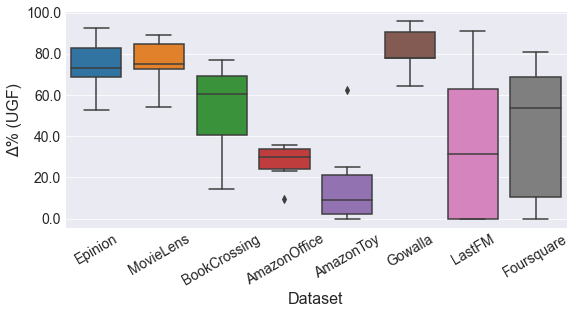

In [19]:
# Figure 1
# generating boxplot for all datasets on the improvement on UGF

ax, fig = plt.subplots(figsize=[9,4])
p = sns.boxplot(x="Dataset", y="impUGF", data=boxplot_df[boxplot_df.Type == 'Fair'])
p.set_yticklabels(np.round(p.get_yticks(), 4), fontsize=14)
p.set_xticklabels(p.get_xticklabels(), fontsize=14)
p.set_ylabel(r'Δ% (UGF)', fontsize=16)
p.set_xlabel('Dataset', fontsize=16)
p.set_xticklabels(p.get_xticklabels(), rotation=30)

plt.savefig(f'plots/{user_groups}/boxplot_ds_{user_groups}.pdf', bbox_inches='tight')

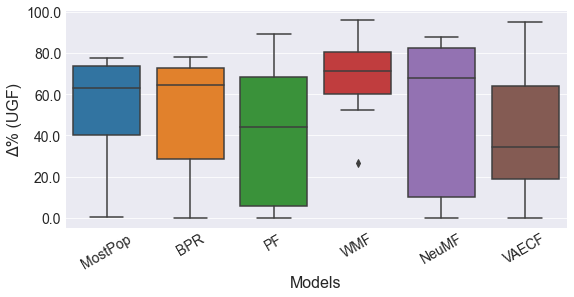

In [20]:
# Figure 4
# generating boxplot for all models on the improvement on UGF

ax, fig = plt.subplots(figsize=[9,4])
p = sns.boxplot(x="Model", y="impUGF", data=boxplot_df[boxplot_df.Type == 'Fair'])
p.set_yticklabels(np.round(p.get_yticks(), 4), fontsize=14)
p.set_xticklabels(p.get_xticklabels(), fontsize=14)
p.set_ylabel(r'Δ% (UGF)', fontsize=16)
p.set_xlabel('Models', fontsize=16)
p.set_xticklabels(p.get_xticklabels(), rotation=30)

plt.savefig(f'plots/{user_groups}/boxplot_ml_{user_groups}.pdf', bbox_inches='tight')

> Metric: impNDCG, Pearsonr: 0.55036, P-value: 5.06e-05
> Metric: impNov, Pearsonr: 0.512, P-value: 0.0001994
> Metric: impDeltaGap, Pearsonr: 0.10307, P-value: 0.4857423


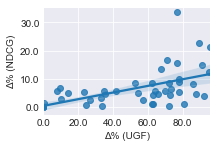

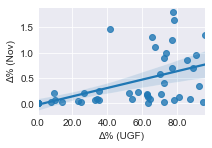

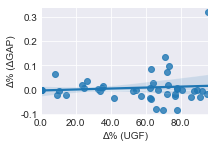

In [21]:
# Figure 3 in the paper
# plots to show the correlation between the improvement of UGF and the other metrics such as NDCG, Novelty and DeltaGap

labels = {'impNDCG': r'Δ% (NDCG)', 'impNov': r'Δ% (Nov)', 'impDeltaGap': r'Δ% (ΔGAP)'}
for metric in ['impNDCG', 'impNov', 'impDeltaGap']:
    fig, ax = plt.subplots()
    fig.set_size_inches(3, 2)
    r = sns.regplot(x="impUGF", y=metric, data=boxplot_df[(boxplot_df.Type == 'Fair')], ax=ax)

    # compute the Pearson's correlation and p-value
    fairX_boxplot_df = boxplot_df[(boxplot_df.Type == 'Fair')]
    pearsonr, pvalue = sp.stats.pearsonr(fairX_boxplot_df['impUGF'], fairX_boxplot_df[metric])
    print(f"> Metric: {metric}, Pearsonr: {round(pearsonr, 5)}, P-value: {round(pvalue, 7)}")

    # set ticks
    r.set_yticklabels(np.round(r.get_yticks(), 4), fontsize=10)
    r.set_xticklabels(np.round(r.get_xticks(), 4), fontsize=10)
    # set labels
    r.set_ylabel(f"{labels[metric]}", fontsize=10)
    r.set_xlabel(r'Δ% (UGF)', fontsize=10)

    # save the figure
    fig.savefig(f'plots/{user_groups}/boxplot_corr_{metric}_{user_groups}.pdf', bbox_inches='tight')